In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Re-prepare dataset
X, y = make_moons(n_samples=1000, noise=0.1, random_state=42)
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_train, dtype=torch.long).to(device)
X_test_t = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_t = torch.tensor(y_test, dtype=torch.long).to(device)

# MLP
class MLP(nn.Module):
    def __init__(self, input_dim=2, hidden=20):
        super().__init__()
        self.hidden_dim = hidden
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 2)
        )

    def forward(self, x):
        return self.net(x)

# Van der Pol ONN
class VanDerPolONN(nn.Module):
    def __init__(self, input_dim, num_osc, T=2.0, dt=0.01, mu=1.5):
        super().__init__()
        self.N = num_osc
        self.T = T
        self.steps = int(T / dt)
        self.dt = dt
        self.mu = mu
        self.in_x = nn.Linear(input_dim, self.N)
        self.in_y = nn.Linear(input_dim, self.N)
        self.A = nn.Parameter(torch.randn(self.N, self.N) * 0.1)
        self.readout = nn.Linear(2 * self.N, 2)

    def forward(self, x_input):
        batch = x_input.size(0)
        x = self.in_x(x_input)
        y = self.in_y(x_input)
        K = torch.nn.functional.softplus(self.A + self.A.t()) / self.N
        for _ in range(self.steps):
            dx = y
            dy = self.mu * (1 - x**2) * y - x
            diff_x = x.unsqueeze(2) - x.unsqueeze(1)
            coup = torch.einsum('bij,ij->bi', diff_x, K)
            dy = dy + coup
            x = x + self.dt * dx
            y = y + self.dt * dy
        feats = torch.cat([x, y], dim=1)
        return self.readout(feats)

# Train function with logging
def train_model_verbose(model, X_tr, y_tr, X_val, y_val, epochs=50, lr=1e-3):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()
    train_losses, val_losses, accs = [], [], []

    for epoch in range(1, epochs + 1):
        model.train()
        optimizer.zero_grad()
        logits = model(X_tr)
        loss = loss_fn(logits, y_tr)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        model.eval()
        with torch.no_grad():
            val_logits = model(X_val)
            val_loss = loss_fn(val_logits, y_val).item()
            preds = val_logits.argmax(dim=1)
            acc = (preds == y_val).float().mean().item()
            val_losses.append(val_loss)
            accs.append(acc)

        if epoch % 10 == 0 or epoch == 1:
            print(f"Epoch {epoch:2d} | Train Loss: {loss.item():.4f} | "
                  f"Val Loss: {val_loss:.4f} | Acc: {acc:.3f}")
    return accs[-1]


# Train both models
mlp_model = MLP(hidden=300)
onn_model = VanDerPolONN(input_dim=2, num_osc=4, T=15.0, dt=0.01, mu=1.5)
epoch_MLP = 200 
epoch_ONN = 300

print("\nTraining MLP...")
acc_mlp = train_model_verbose(mlp_model, X_train_t, y_train_t, X_test_t, y_test_t, epochs = epoch_MLP)

print("\nTraining Van der Pol ONN...")
acc_onn = train_model_verbose(onn_model, X_train_t, y_train_t, X_test_t, y_test_t, epochs = epoch_ONN)





Training MLP...
Epoch  1 | Train Loss: 0.6873 | Val Loss: 0.6382 | Acc: 0.673
Epoch 10 | Train Loss: 0.3725 | Val Loss: 0.3448 | Acc: 0.910
Epoch 20 | Train Loss: 0.2693 | Val Loss: 0.2493 | Acc: 0.913
Epoch 30 | Train Loss: 0.2374 | Val Loss: 0.2173 | Acc: 0.917
Epoch 40 | Train Loss: 0.2223 | Val Loss: 0.2018 | Acc: 0.917
Epoch 50 | Train Loss: 0.2117 | Val Loss: 0.1912 | Acc: 0.927
Epoch 60 | Train Loss: 0.2019 | Val Loss: 0.1815 | Acc: 0.930
Epoch 70 | Train Loss: 0.1919 | Val Loss: 0.1720 | Acc: 0.930
Epoch 80 | Train Loss: 0.1816 | Val Loss: 0.1626 | Acc: 0.933
Epoch 90 | Train Loss: 0.1711 | Val Loss: 0.1532 | Acc: 0.937
Epoch 100 | Train Loss: 0.1604 | Val Loss: 0.1436 | Acc: 0.940
Epoch 110 | Train Loss: 0.1496 | Val Loss: 0.1339 | Acc: 0.950
Epoch 120 | Train Loss: 0.1389 | Val Loss: 0.1244 | Acc: 0.953
Epoch 130 | Train Loss: 0.1285 | Val Loss: 0.1152 | Acc: 0.967
Epoch 140 | Train Loss: 0.1185 | Val Loss: 0.1063 | Acc: 0.973
Epoch 150 | Train Loss: 0.1090 | Val Loss: 0.097

In [4]:
print("\nTraining Van der Pol ONN...")
acc_onn = train_model_verbose(onn_model, X_train_t, y_train_t, X_test_t, y_test_t, epochs = 100)


Training Van der Pol ONN...
Epoch  1 | Train Loss: 0.2171 | Val Loss: 0.2802 | Acc: 0.920
Epoch 10 | Train Loss: 0.2094 | Val Loss: 0.2754 | Acc: 0.923
Epoch 20 | Train Loss: 0.2032 | Val Loss: 0.2667 | Acc: 0.923
Epoch 30 | Train Loss: 0.1977 | Val Loss: 0.2642 | Acc: 0.927
Epoch 40 | Train Loss: 0.1926 | Val Loss: 0.2604 | Acc: 0.923
Epoch 50 | Train Loss: 0.1882 | Val Loss: 0.2580 | Acc: 0.923
Epoch 60 | Train Loss: 0.1840 | Val Loss: 0.2576 | Acc: 0.927
Epoch 70 | Train Loss: 0.1802 | Val Loss: 0.2532 | Acc: 0.927
Epoch 80 | Train Loss: 0.1766 | Val Loss: 0.2496 | Acc: 0.927
Epoch 90 | Train Loss: 0.1732 | Val Loss: 0.2472 | Acc: 0.927
Epoch 100 | Train Loss: 0.1700 | Val Loss: 0.2450 | Acc: 0.927


In [2]:
def estimate_energy_latency(model_type, input_dim=2, hidden_dim=20, N=10, T_sim=2.0, dt=0.01, f_osc=1e6,
                            use_mac_based_latency=False, macs_per_second=1e9):
    T_real = T_sim / f_osc  # scale sim time to physical time

    energy_per_mac = 1e-12       # 1 pJ
    power_per_osc = 1e-3         # 1 mW = 1e-3 W per oscillator
    digital_latency_per_layer = 1e-6  # 1 µs per layer if fixed
    time_per_mac = 1 / macs_per_second

    if model_type == 'MLP':
        macs_input = input_dim * hidden_dim
        macs_output = hidden_dim * 2
        total_macs = macs_input + macs_output
        energy = total_macs * energy_per_mac

        if use_mac_based_latency:
            latency = total_macs * time_per_mac
        else:
            latency = 2 * digital_latency_per_layer

        power = energy / latency

        print('----MLP----')
        print('hidden_dim:', hidden_dim)
        print(f'Total MACs: {total_macs}')
        print(f'Digital latency: {latency * 1e6:.2f} us')

    elif model_type == 'ONN':
        macs_input = input_dim * N * 2
        macs_output = 2 * N
        total_macs = macs_input + macs_output
        energy_mac = total_macs * energy_per_mac

        if use_mac_based_latency:
            digital_latency_total = total_macs * time_per_mac
        else:
            digital_latency_total = 2 * digital_latency_per_layer

        digital_power = energy_mac / digital_latency_total

        analog_power = N * power_per_osc  # in W
        energy = energy_mac + analog_power * T_real
        latency = digital_latency_total + T_real
        power = digital_power + analog_power

        print('----ONN----')
        print('# of osc:', N)
        print(f'Total MACs: {total_macs}')
        print(f'Digital latency: {digital_latency_total * 1e6:.2f} us')
        print(f'Analog latency (T_real): {T_real * 1e6:.2f} us')
        print(f'Analog power: {analog_power * 1e3:.3f} mW')

    else:
        raise ValueError("Unknown model type.")

    return energy * 1e9, power * 1e3, latency * 1e6  # return in nJ, mW, µs


# Energy and latency estimates

use_mac = True
energy_mlp, power_mlp, latency_mlp = estimate_energy_latency('MLP', input_dim=2, hidden_dim=mlp_model.hidden_dim,
                                                             use_mac_based_latency=use_mac)
energy_onn, power_onn, latency_onn = estimate_energy_latency('ONN', input_dim=2, N=onn_model.N, T_sim=onn_model.T, 
                                                             f_osc=1e9, use_mac_based_latency=use_mac)

print("\n=== Performance Summary ===")
print(f"MLP  → Acc: {acc_mlp:.3f}, Energy/inference: {energy_mlp:.3f} nJ, Power: {power_mlp:.2f} mW, Latency: {latency_mlp:.2f} us")
print(f"ONN  → Acc: {acc_onn:.3f}, Energy/inference: {energy_onn:.3f} nJ, Power: {power_onn:.2f} mW, Latency: {latency_onn:.2f} us")


----MLP----
hidden_dim: 300
Total MACs: 1200
Digital latency: 1.20 us
----ONN----
# of osc: 4
Total MACs: 24
Digital latency: 0.02 us
Analog latency (T_real): 0.01 us
Analog power: 4.000 mW

=== Performance Summary ===
MLP  → Acc: 0.990, Energy/inference: 1.200 nJ, Power: 1.00 mW, Latency: 1.20 us
ONN  → Acc: 0.857, Energy/inference: 0.084 nJ, Power: 5.00 mW, Latency: 0.04 us


In [20]:
def estimate_energy_latency(model_type, input_dim=2, hidden_dim=20, N=10, T_sim=2.0, dt=0.01, f_osc=1e6,
                            use_mac_based_latency=False, macs_per_second=1e9):
    Num_cycles = T_sim / (2*np.pi)
    T_real = Num_cycles / f_osc  # scale sim time to physical time

    energy_per_mac = 1e-12       # 1 pJ
    power_per_osc = 1e-3         # 1 mW = 1e-3 W per oscillator
    digital_latency_per_layer = 1e-6  # 1 µs per layer if fixed
    time_per_mac = 1 / macs_per_second

    if model_type == 'MLP':
        macs_input = input_dim * hidden_dim
        macs_output = hidden_dim * 2
        total_macs = macs_input + macs_output
        energy = total_macs * energy_per_mac

        if use_mac_based_latency:
            latency = total_macs * time_per_mac
        else:
            latency = 2 * digital_latency_per_layer

        power = energy / latency

        print('----MLP----')
        print('hidden_dim:', hidden_dim)
        print(f'Total MACs: {total_macs}')
        print(f'Digital latency: {latency * 1e6:.3f} us')

    elif model_type == 'ONN':
        macs_input = input_dim * N * 2
        macs_output = 2 * N
        total_macs = macs_input + macs_output
        energy_mac = total_macs * energy_per_mac

        if use_mac_based_latency:
            digital_latency_total = total_macs * time_per_mac
        else:
            digital_latency_total = 2 * digital_latency_per_layer

        digital_power = energy_mac / digital_latency_total

        analog_power = N * power_per_osc  # in W
        energy = energy_mac + analog_power * T_real
        latency = digital_latency_total + T_real
        power = digital_power + analog_power

        print('----ONN----')
        print('# of osc:', N)
        print(f'Total MACs: {total_macs}')
        print(f'Digital latency: {digital_latency_total * 1e6:.3f} us')
        print(f'Analog latency (T_real): {T_real * 1e9:.3f} ns')
        print(f'Digital power: {analog_power * 1e3:.3f} mW')
        print(f'Analog power: {analog_power * 1e3:.3f} mW')

    else:
        raise ValueError("Unknown model type.")

    return energy * 1e9, power * 1e3, latency * 1e6  # return in nJ, mW, µs


# Energy and latency estimates

use_mac = True
energy_mlp, power_mlp, latency_mlp = estimate_energy_latency('MLP', input_dim=2, hidden_dim=mlp_model.hidden_dim,
                                                             use_mac_based_latency=use_mac)
energy_onn, power_onn, latency_onn = estimate_energy_latency('ONN', input_dim=2, N=2, T_sim=15, 
                                                             f_osc=1e9, use_mac_based_latency=use_mac)

print("\n=== Performance Summary ===")
print(f"MLP  → Acc: {acc_mlp:.3f}, Energy/inference: {energy_mlp:.3f} nJ, Power: {power_mlp:.3f} mW, Latency: {latency_mlp:.3f} us")
print(f"ONN  → Acc: {acc_onn:.3f}, Energy/inference: {energy_onn:.3f} nJ, Power: {power_onn:.3f} mW, Latency: {latency_onn:.3f} us")


----MLP----
hidden_dim: 300
Total MACs: 1200
Digital latency: 1.200 us
----ONN----
# of osc: 2
Total MACs: 12
Digital latency: 0.012 us
Analog latency (T_real): 2.387 ns
Digital power: 2.000 mW
Analog power: 2.000 mW

=== Performance Summary ===
MLP  → Acc: 0.990, Energy/inference: 1.200 nJ, Power: 1.000 mW, Latency: 1.200 us
ONN  → Acc: 0.927, Energy/inference: 0.017 nJ, Power: 3.000 mW, Latency: 0.014 us


In [16]:
(2.4/(2*np.pi*1e9))

3.819718634205488e-10

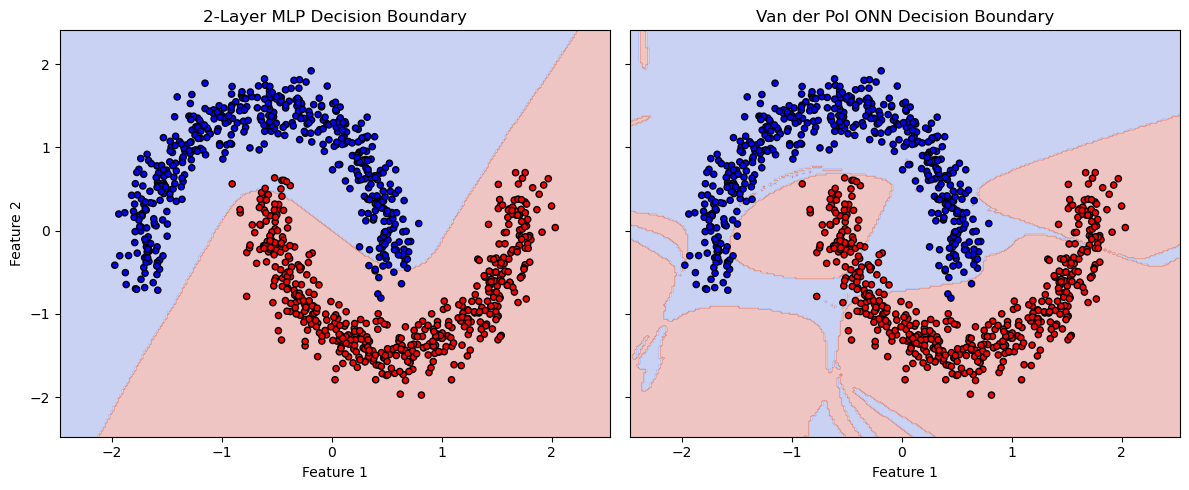

In [5]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler

# -- Re-create dataset and scaler (must match training preprocessing) --
X, y = make_moons(n_samples=1000, noise=0.1, random_state=42)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# -- Move models to CPU and evaluation mode --
mlp_model = mlp_model.to('cpu').eval()
onn_model = onn_model.to('cpu').eval()

# -- Create meshgrid over feature space --
h = 0.02
x_min, x_max = X_scaled[:, 0].min() - 0.5, X_scaled[:, 0].max() + 0.5
y_min, y_max = X_scaled[:, 1].min() - 0.5, X_scaled[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
grid = np.c_[xx.ravel(), yy.ravel()]
grid_t = torch.tensor(grid, dtype=torch.float32)

# -- Predict on grid for both models --
with torch.no_grad():
    logits_mlp = mlp_model(grid_t)
    preds_mlp = torch.softmax(logits_mlp, dim=1).argmax(dim=1).numpy()
    
    logits_onn = onn_model(grid_t)
    preds_onn = torch.softmax(logits_onn, dim=1).argmax(dim=1).numpy()

# -- Plot side-by-side decision boundaries --
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# MLP boundary
axes[0].contourf(xx, yy, preds_mlp.reshape(xx.shape), alpha=0.3, cmap='coolwarm')
axes[0].scatter(X_scaled[:, 0], X_scaled[:, 1], c=y, cmap='bwr', edgecolors='k', s=20)
axes[0].set_title('2-Layer MLP Decision Boundary')
axes[0].set_xlabel('Feature 1')
axes[0].set_ylabel('Feature 2')

# ONN boundary
axes[1].contourf(xx, yy, preds_onn.reshape(xx.shape), alpha=0.3, cmap='coolwarm')
axes[1].scatter(X_scaled[:, 0], X_scaled[:, 1], c=y, cmap='bwr', edgecolors='k', s=20)
axes[1].set_title('Van der Pol ONN Decision Boundary')
axes[1].set_xlabel('Feature 1')

plt.tight_layout()
plt.show()
